In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/us-accidents/US_Accidents_May19.csv


* About the data:
This is a countrywide traffic accident dataset, which covers 49 states of the United States. The data is continuously being collected from February 2016, using several data providers, including two APIs which provide streaming traffic event data. These APIs broadcast traffic events captured by a variety of entities, such as the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road-networks. Currently, there are about 2.25 million accident records in this dataset.
                     
* What questions are we trying to answer:
    * Source of Information
    * How Severe the accidents are
    * Which County, zip codes recorded maximum accidents    
    * Major Contributors for Severe accidents
    * Which month/year had how much accidents and if there id a trend
    * Relationship of environmental factors contributing to the accident
    * Which time of the day has most accidents
    * Deep dive into bi-varite relationship of the columns with Severity

In [2]:
# Read the dataset
acc_df = pd.read_csv('../input/us-accidents/US_Accidents_May19.csv')

In [3]:
# First Look into the data
print('Rows, Columns - ', acc_df.shape)
acc_df.head()

Rows, Columns -  (2243939, 49)


,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
# Get Attribute and Datatype Information
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 49 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               object
End_Time                 object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi

In [5]:
# Data represents how many States ?
print(f"Data represents {acc_df['State'].unique().shape[0]} states")

Data represents 49 states


In [6]:
# Converting timestamp fileds into datetime.
acc_df['Start_Time'] = pd.to_datetime(acc_df['Start_Time'], infer_datetime_format=True)
acc_df['End_Time'] = pd.to_datetime(acc_df['End_Time'], infer_datetime_format=True)
acc_df['Weather_Timestamp'] = pd.to_datetime(acc_df['Weather_Timestamp'], infer_datetime_format=True)

In [7]:
# Missing Data
missing_data = []
total = acc_df.isna().sum()
percentage = round((acc_df.isna().sum()/acc_df.isna().count())*100, 0).astype(int)
missing_data = pd.concat([total, percentage], axis=1, keys=['Sum', 'Percentage(%)'])
missing_data = missing_data.sort_values('Percentage(%)', ascending=False)
missing_data

,Sum,Percentage(%)
Precipitation(in),1979466,88
Wind_Chill(F),1852370,83
End_Lat,1727177,77
End_Lng,1727177,77
Number,1458402,65
TMC,516762,23
Wind_Speed(mph),442954,20
Visibility(mi),71360,3
Pressure(in),57280,3
Humidity(%),64467,3


**** Missing Summary and Action :****
* Precipitation has 88% missing data. Meaning, 88% of the days, it didn't rain. We will replace the missing values with 0.
* Wind Chill has 83% missing data. So windchill was not presen during those days and will be replaced by 0.
* End_Lat and End_Lng has 77% missing data. We will not use this field for analysis. We will use Start_Lat and Start_Lng intead.
* Number - 65% Street numbers missing. These could be accidents on main highways (US Routes, Interstates etc). We will replace them with 0s. 0s will represent highways and others as Non highways.
* TMC - 20% missing data. Traffic Message Channel (TMC) is a technology for delivering traffic and travel information to motor vehicle drivers. We will replace missing values with 0
* Wind Speed - 20% missing. We will assume there is no wind and replace them with 0.
* Others with 2-3% missing, replace with 0.

In [8]:
# Replace missing values with 0s
acc_df = acc_df.fillna(0)

In [9]:
# Missing Data
missing_data = []
total = acc_df.isna().sum()
percentage = round((acc_df.isna().sum()/acc_df.isna().count())*100, 0).astype(int)
missing_data = pd.concat([total, percentage], axis=1, keys=['Sum', 'Percentage(%)'])
missing_data = missing_data.sort_values('Percentage(%)', ascending=False)
missing_data

,Sum,Percentage(%)
ID,0,0
Humidity(%),0,0
Visibility(mi),0,0
Wind_Direction,0,0
Wind_Speed(mph),0,0
Precipitation(in),0,0
Weather_Condition,0,0
Amenity,0,0
Bump,0,0
Crossing,0,0


In [10]:
acc_df['Counter']=1

In [11]:
# Determining the timeframe of the data
print( 'State Date - ', acc_df['Start_Time'].min(), '\nEnd Date   - ', acc_df['Start_Time'].max())

State Date -  2015-03-09 07:00:00 
End Date   -  2019-04-01 03:26:00


We have 4 years worth of data. We will use the timeframe reference down the line

Source of information:
----------------------
MapQuest         76%
Bing             23%
MapQuest-Bing     1%
Name: Source, dtype: object


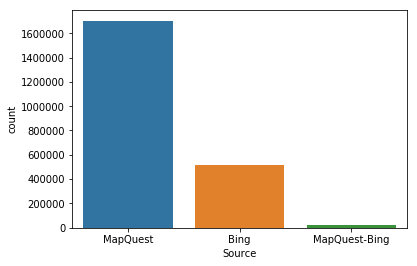

In [12]:
# Different sources providing accident details 
print('Source of information:')
print('----------------------')
print((round(acc_df['Source'].value_counts(normalize=True)*100, 0)).astype(int).astype(str) + '%')
ax = sns.countplot(x="Source", data=acc_df, order = acc_df['Source'].value_counts().index)

# TMC
Reference : https://en.wikipedia.org/wiki/Traffic_message_channel

Traffic Message Channel (TMC) is a technology for delivering traffic and travel information to motor vehicle drivers. 
It is digitally coded using the ALERT C or TPEG protocol into RDS Type 8A groups carried via conventional FM radio broadcasts.
When data is integrated directly into a navigation system, traffic information can be used in the system's route calculation.

Frequency Distribution of TMC
Code       Frequency 
-----------------------------
201.0    1464118
0.0       516762
241.0     150939
245.0      27509
229.0      21957
203.0      14114
222.0      11576
244.0       8416
406.0       6824
202.0       5102
246.0       4739
247.0       4133
343.0       2847
236.0       1919
248.0        952
206.0        857
339.0        629
341.0        361
200.0         66
336.0         62
239.0         51
351.0          6
Name: TMC, dtype: int64


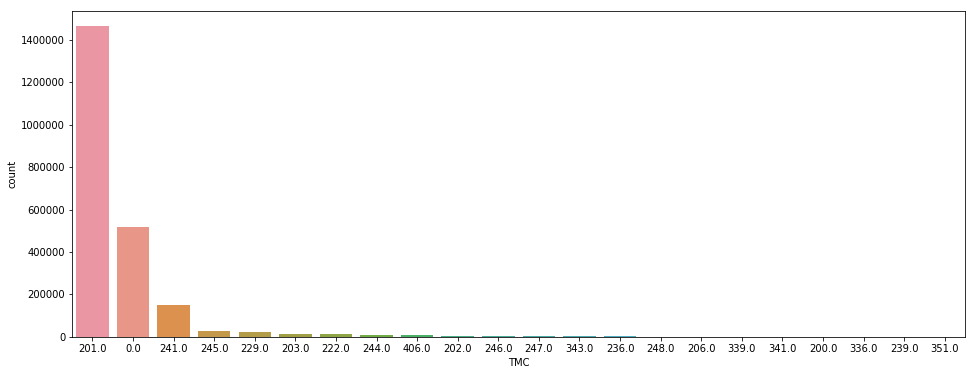

In [13]:
# Frequency Distribution of TMC (Note - 0 represents missing data. 0 is not a valid TMC Code)
print('Frequency Distribution of TMC')
print('Code       Frequency ')
print('-----------------------------')
plt.figure(figsize = (16, 6))
print(acc_df['TMC'].value_counts())
sns.countplot(x="TMC", data=acc_df, order = acc_df['TMC'].value_counts().index)

In [14]:
# TMC Labels refence - https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List
tmc_code_labels = ['(Q) accident(s)','Missing TMC Code',
'(Q) accident(s). Right lane blocked',
'(Q) accident(s). Two lanes blocked',
'(Q) accident(s). Slow traffic',
'multi-vehicle accident (involving Q vehicles)',
'(Q) accident(s). Queuing traffic',
'(Q) accident(s). Hard shoulder blocked',
'(Q th) entry slip road closed',
'(Q) serious accident(s)',
'(Q) accident(s). Three lanes blocked',
'accident. Delays (Q)',
'(Q) earlier accident(s)',
'(Q) accident(s). Heavy traffic',
'accident. Delays (Q) expected',
'(Q) fuel spillage accident(s)',
'(Q) jackknifed trailer(s)',
'(Q) jackknifed articulated lorr(y/ies)',
'multi vehicle pile up. Delays (Q)',
'(Q) oil spillage accident(s)',
'(Q) accident(s). Traffic building up',
'(Q) accident(s) in roadworks area']

In [15]:
# Create a lookup of TMC Code and Description. This will give us an idea of whats these codes mean
values = acc_df['TMC'].value_counts().keys().astype(int).tolist()
counts = acc_df['TMC'].value_counts().tolist()
tmc_lookup_df = pd.DataFrame({'TMC_CODE':values, 'TMC_CODE_DESC': tmc_code_labels, 'COUNT':counts})
tmc_lookup_df

,TMC_CODE,TMC_CODE_DESC,COUNT
0,201,(Q) accident(s),1464118
1,0,Missing TMC Code,516762
2,241,(Q) accident(s). Right lane blocked,150939
3,245,(Q) accident(s). Two lanes blocked,27509
4,229,(Q) accident(s). Slow traffic,21957
5,203,multi-vehicle accident (involving Q vehicles),14114
6,222,(Q) accident(s). Queuing traffic,11576
7,244,(Q) accident(s). Hard shoulder blocked,8416
8,406,(Q th) entry slip road closed,6824
9,202,(Q) serious accident(s),5102


Severity:
---------
2    64%
3    31%
4     3%
1     0%
0     0%
Name: Severity, dtype: object


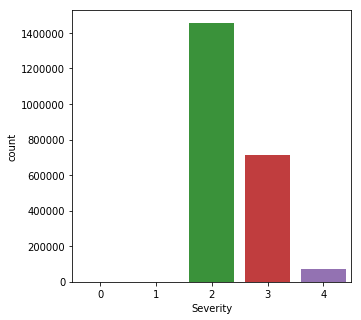

In [16]:
# Frequency Distribution for Severity
plt.figure(figsize = (5, 5))
print('Severity:')
print('---------')
print((acc_df['Severity'].value_counts(normalize=True)*100).astype(int).astype(str) + '%')
sns.countplot(x='Severity', data=acc_df)

* 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay)
* Severity 2 constitute the Majority

In [17]:
# Creating a new column called Accident Duration
acc_df['Accident_Duration_Mins'] = (acc_df['End_Time'] - acc_df['Start_Time']).astype('timedelta64[m]').astype(int)

In [18]:
# Accident Duration by Severity
acc_duration = acc_df[['Accident_Duration_Mins']].groupby(acc_df['Severity']).agg(['count', 'mean', 'std', 'median', 'min', 'max']).astype(int).round()
acc_duration

Accident_Duration_Mins                                 
                          count  mean    std median min      max
Severity                                                        
0                            17    49     50     29  28      239
1                           814    40     16     30  17      216
2                       1455524   108   1218     40 -31   500221
3                        715582    78   2204     29 -31   782609
4                         72002  1102  21613    360  11  1786320

Observations:
* Severity - 4 : Mean 1102 mins with std dev 21613 mins means, (1102+21613)/60 = 378 hrs =  15 days. I doubt the data here. Rather we will use the median. It creates 360 mins or 6 hrs delays to clear a severity 4 accidents.
* Severity - 3 : Median 29 mins . Min shows -31. Presence of Data issue (Start_Time > End_Time).
* Severity - 2 : Median 40 mins. Min shows -31. Presence of Data issue (Start_Time > End_Time).
* Severity -1  : Only 17 records. So difficult to reach any conclusion as sample size is statistically insignificant (min 30 samples required). 

Text(0.5, 1.0, 'Count of accidents by State')

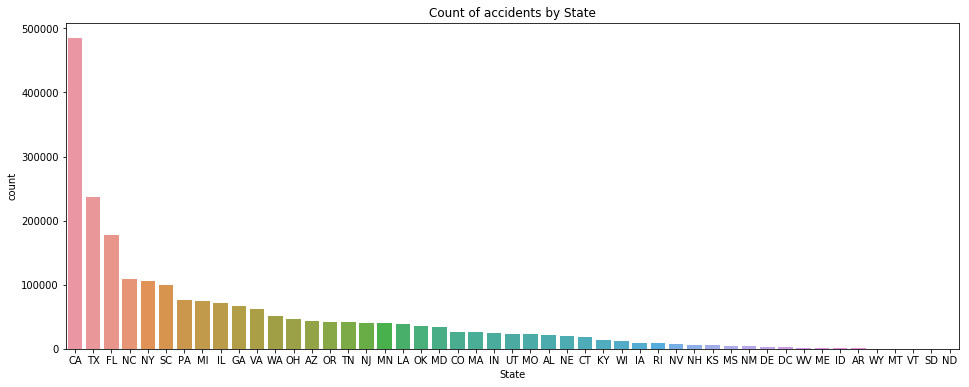

In [19]:
# No of accidents by States
plt.figure(figsize = (16, 6))
sns.countplot(x='State', data=acc_df, order = acc_df['State'].value_counts().index)
plt.title('Count of accidents by State')

California, Texas, Florida, North Carolina and New York recoded maximum number of accidents.

Let's deep dive more into these states

In [20]:
# Select top 5 states
acc_df_top_state = acc_df[acc_df['State'].isin(['CA', 'TX', 'FL', 'NC', 'NY'])][['Start_Time', 'State', 'Severity']]

In [21]:
# How many accidents happened in last 4 years in top 5 states
acc_df_top_state['State'].value_counts()

CA    484706
TX    237637
FL    177490
NC    108916
NY    105523
Name: State, dtype: int64

In [22]:
# Breakup of accidents by Severity
acc_df_top_state['COUNTER'] =1
acc_df_top_state.groupby(['State','Severity'])['COUNTER'].sum()

State  Severity
CA     0                4
       1              231
       2           298270
       3           181310
       4             4891
FL     1               62
       2           114707
       3            57556
       4             5165
NC     0                1
       1               20
       2            93208
       3            13927
       4             1760
NY     0                1
       1               19
       2            60284
       3            40919
       4             4300
TX     0                4
       1              105
       2           170484
       3            64355
       4             2689
Name: COUNTER, dtype: int64

* Severity 4  - Florida Leads followed by California and New York
* Severity 3  - California Leads followed by Texas and Florida
* Severity 2  - California followed by Texas and Florida
* Severity 1  - California followed by Texas
* Severity 0  - 10 records only. Sample size insufficient to conclude.

In [23]:
# Extract Year and Month of accident from Start_Time
acc_df_top_state['Year'] = acc_df_top_state['Start_Time'].map(lambda x: x.year)
acc_df_top_state['Month'] = acc_df_top_state['Start_Time'].map(lambda x: x.month)
acc_df_top_state[['Start_Time', 'Year', 'Month']].head()

,Start_Time,Year,Month
728,2016-06-21 10:34:40,2016,6
729,2016-06-21 10:30:16,2016,6
730,2016-06-21 10:49:14,2016,6
731,2016-06-21 10:41:42,2016,6
732,2016-06-21 10:16:26,2016,6


Year
2016    253428
2017    369841
2018    400768
2019     90235
Name: COUNTER, dtype: int64


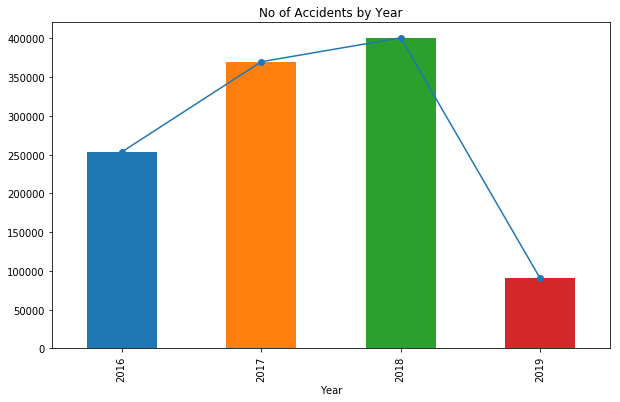

In [24]:
# Breakup of Accident by Year
plt.figure(figsize = (10, 6))
print(acc_df_top_state.groupby(['Year'])['COUNTER'].sum())
ax = acc_df_top_state.groupby(['Year'])['COUNTER'].sum().plot(kind='line', linestyle='-', marker='o', use_index=False)
acc_df_top_state.groupby(['Year'])['COUNTER'].sum().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3'], title='No of Accidents by Year', ax=ax)

* Accidents Kept increasing from 2016 to 2018.
* Accidents comparatively looks low in 2016 since data start from Mar 2016. Jan/feb is missing.
* Accident Sharply declined in 2019 since for 2019, we have data till Apr'19.

Month
1      97312
2      91056
3     103299
4      79114
5      73921
6      79006
7      82317
8     105856
9      99232
10    104450
11    106232
12     92477
Name: COUNTER, dtype: int64


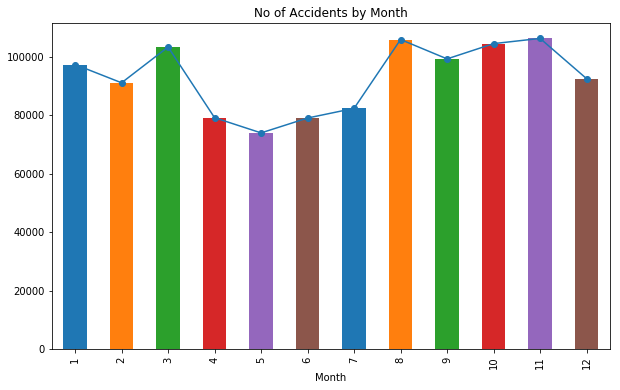

In [25]:
# Breakup of Accident by Month
plt.figure(figsize = (10, 6))
print(acc_df_top_state.groupby(['Month'])['COUNTER'].sum())
ax = acc_df_top_state.groupby(['Month'])['COUNTER'].sum().plot(kind='line', linestyle='-', marker='o', use_index=False)
acc_df_top_state.groupby(['Month'])['COUNTER'].sum().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], title='No of Accidents by Month', ax=ax)

* March, August, October and November has highest number of accidents

Month
1     64427
2     61034
3     69031
4     52221
5     48686
6     49314
7     52612
8     70707
9     65755
10    70169
11    71288
12    61709
Name: COUNTER, dtype: int64


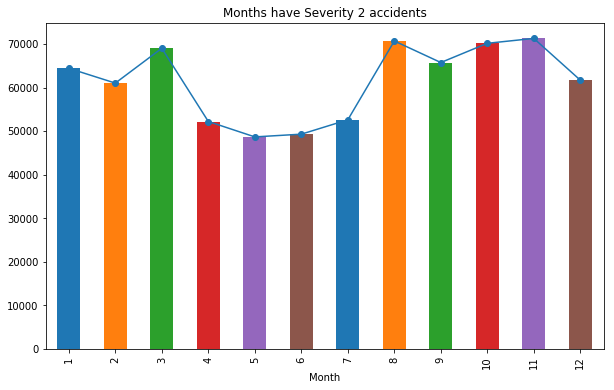

In [26]:
# Which months have most severe 2 accidents
plt.figure(figsize = (10, 6))
print(acc_df_top_state.loc[acc_df_top_state["Severity"] == 2].groupby(['Month'])['COUNTER'].sum())
ax = acc_df_top_state.loc[acc_df_top_state["Severity"] == 2].groupby(['Month'])['COUNTER'].sum().plot(kind='line', linestyle='-', marker='o', use_index=False)
acc_df_top_state.loc[acc_df_top_state["Severity"] == 2].groupby(['Month'])['COUNTER'].sum().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], title='Months have Severity 2 accidents', ax=ax)

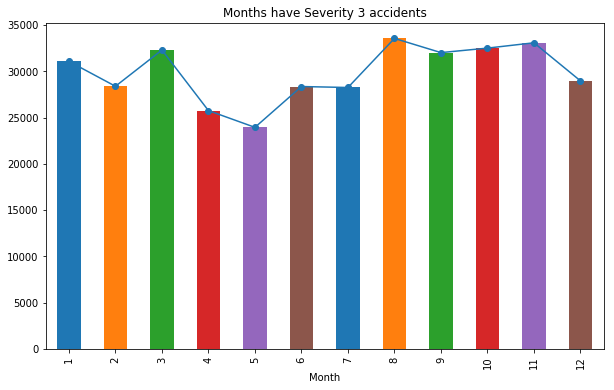

In [27]:
# Which months have most severe 3 accidents
plt.figure(figsize = (10, 6))
# print(acc_df_top_state.loc[acc_df_top_state["Severity"] == 2].groupby(['Month'])['COUNTER'].sum())
ax = acc_df_top_state.loc[acc_df_top_state["Severity"] == 3].groupby(['Month'])['COUNTER'].sum().plot(kind='line', linestyle='-', marker='o', use_index=False)
acc_df_top_state.loc[acc_df_top_state["Severity"] == 3].groupby(['Month'])['COUNTER'].sum().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], title='Months have Severity 3 accidents', ax=ax)

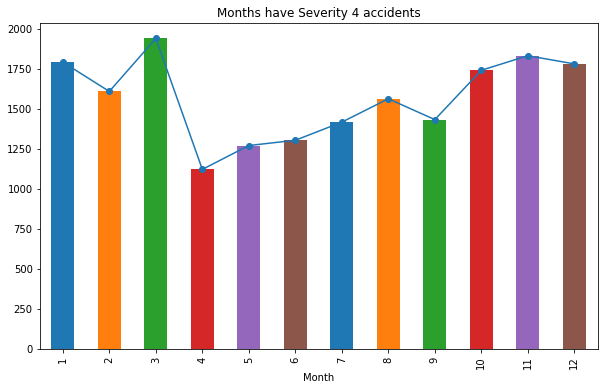

In [28]:
# Which months have most severe 4 accidents
plt.figure(figsize = (10, 6))
# print(acc_df_top_state.loc[acc_df_top_state["Severity"] == 4].groupby(['Month'])['COUNTER'].sum())
ax = acc_df_top_state.loc[acc_df_top_state["Severity"] == 4].groupby(['Month'])['COUNTER'].sum().plot(kind='line', linestyle='-', marker='o', use_index=False)
acc_df_top_state.loc[acc_df_top_state["Severity"] == 4].groupby(['Month'])['COUNTER'].sum().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], title='Months have Severity 4 accidents', ax=ax)

Which months have more Severe accidents ?
* Severity 2 : Mar & Aug
* Severity 3 : Mar, Aug & Nov
* Severity 4 : Mar and Jan

<Figure size 1152x432 with 0 Axes>

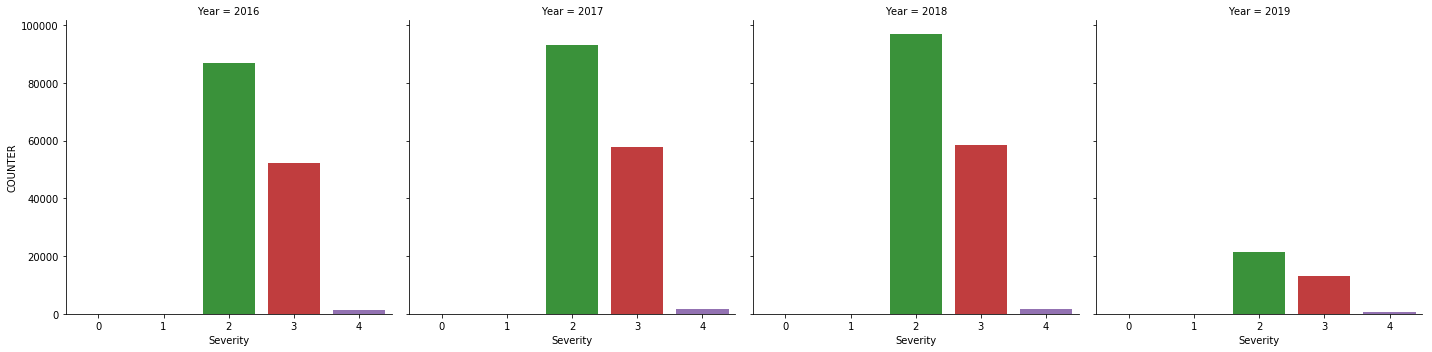

In [29]:
# Breakup of accidents by Severity and Year
plt.figure(figsize = (16, 6))
sby_df = acc_df_top_state.loc[acc_df_top_state["State"] == "CA"].groupby(['Year', 'Severity', 'State'])['COUNTER'].sum().reset_index()
sns.factorplot("Severity", "COUNTER", col="Year", data=sby_df, kind="bar")

* Since 2018 leads in accident, Severity data follows accordingly. Sever 2, 3 4 increased between 2016 to 2018.

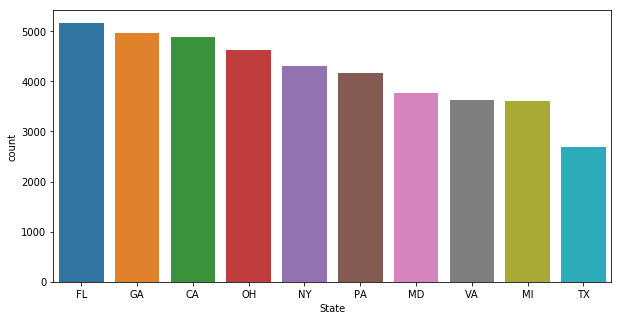

In [30]:
# Which state has highest severity 4 ?
plt.figure(figsize = (10, 5))
acc_sev = acc_df[acc_df.Severity == 4][['State', 'Severity']]
sns.countplot(x='State', data=acc_sev, order = acc_sev['State'].value_counts().iloc[:10].index)

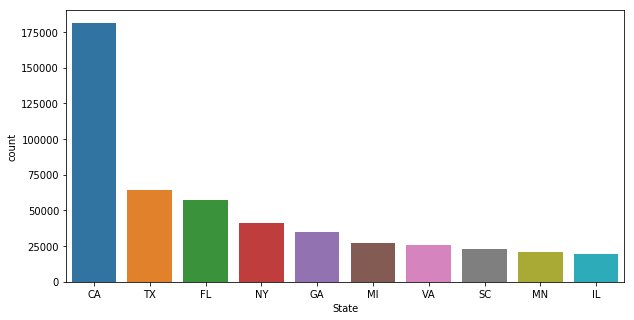

In [31]:
# Which state has highest severity 3 ?
plt.figure(figsize = (10, 5))
acc_sev = acc_df[acc_df.Severity == 3][['State', 'Severity']]
sns.countplot(x='State', data=acc_sev, order = acc_sev['State'].value_counts().iloc[:10].index)

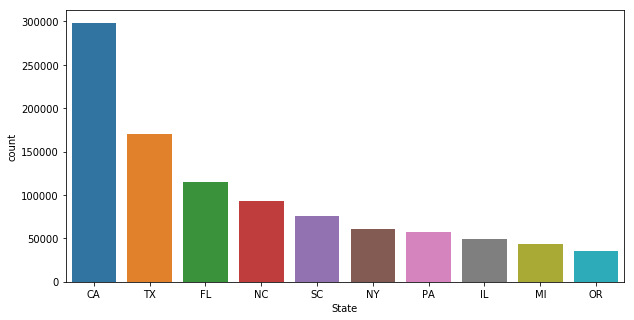

In [32]:
# Which state has highest severity 2 ?
plt.figure(figsize = (10, 5))
acc_sev = acc_df[acc_df.Severity == 2][['State', 'Severity']]
sns.countplot(x='State', data=acc_sev, order = acc_sev['State'].value_counts().iloc[:10].index)

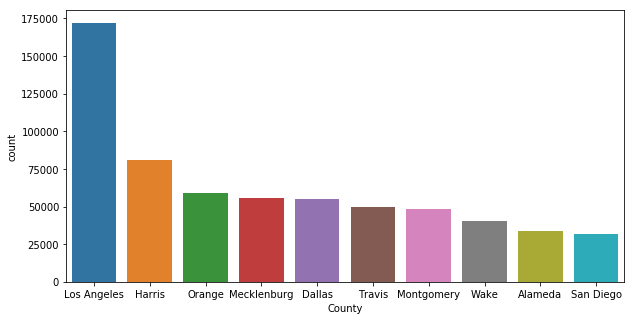

In [33]:
# Top 10 County having highest accidents
plt.figure(figsize = (10, 5))
sns.countplot(x='County', data=acc_df, order = acc_df['County'].value_counts().iloc[:10].index)

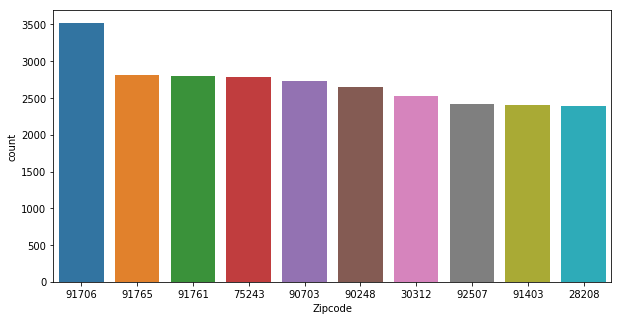

In [34]:
# Top 10 Zip Codes having highest accidents
plt.figure(figsize = (10, 5))
sns.countplot(x='Zipcode', data=acc_df, order = acc_df['Zipcode'].value_counts().iloc[:10].index)

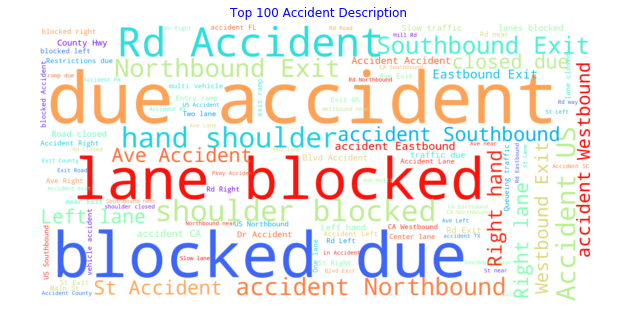

In [35]:
# DescriptionShows natural language description of the accident.
plt.figure(figsize=(10, 6))
desc = acc_df["Description"].str.split("(").str[0].value_counts().keys()
wc_desc = WordCloud(scale=5,max_words=100,colormap="rainbow",background_color="white").generate(" ".join(desc))
plt.imshow(wc_desc,interpolation="bilinear")
plt.axis("off")
plt.title("Top 100 Accident Description",color='b')
plt.show()

In [36]:
# Distance(mi) by Severity The length of the road extent affected by the accident.
acc_df[['Distance(mi)']].groupby(acc_df['Severity']).agg(['count', 'mean', 'median', 'min', 'max'])

Distance(mi)                                  
                count      mean median  min         max
Severity                                               
0                  17  0.065294  0.000  0.0    1.060000
1                 814  0.016081  0.000  0.0    3.300000
2             1455524  0.176903  0.000  0.0  227.210007
3              715582  0.379631  0.000  0.0  333.630005
4               72002  1.623471  0.611  0.0  138.910004

In [37]:
# Which side of Lane has more accidents
print((acc_df['Side'].value_counts(normalize=True)*100).astype(int).astype(str) + '%')

R    82%
L    17%
      0%
Name: Side, dtype: object


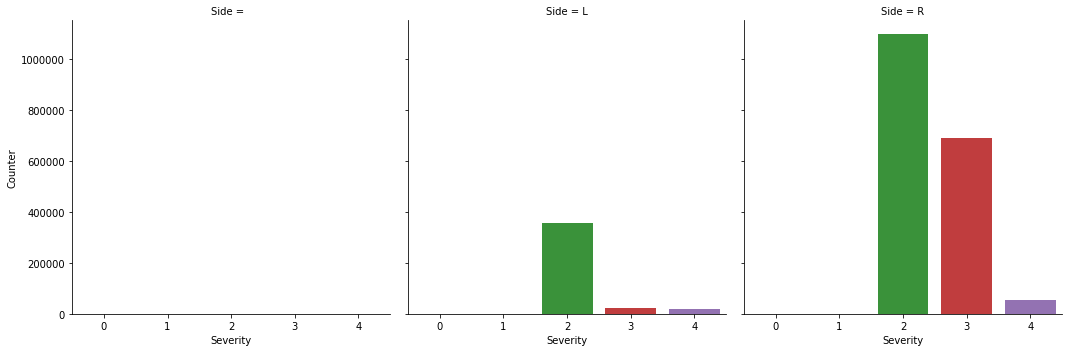

In [38]:
#SideShows the relative side of the street (Right/Left) in address field.
side_df = acc_df.groupby(['Side', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Side", data=side_df, kind="bar")

* US drives on right. Right Side is obvious choice

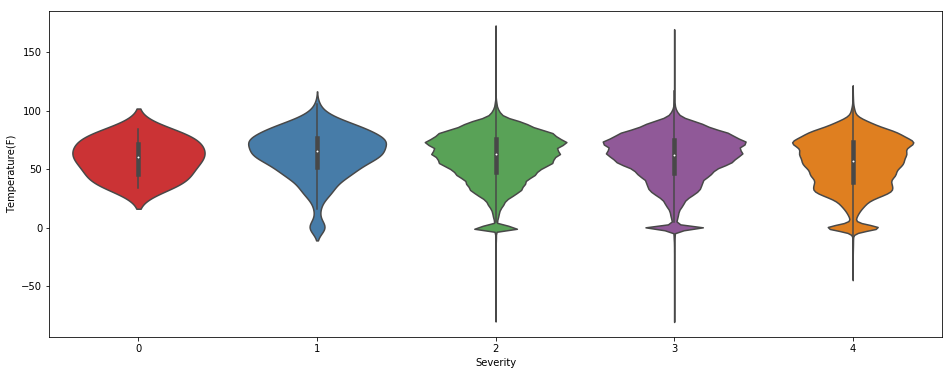

In [39]:
# Severity Impact by Temperature
plt.figure(figsize = (16, 6))
ax = sns.violinplot(y="Temperature(F)", x="Severity", data=acc_df, palette="Set1")

* Median temperature for all severity is at 50 to 60 degrees (F)
* Severity 2, 3, 4 - Density is high around 0 and crosses -50. So mostly winters due to snow, ice etc
* Severity 2, 3, 4 - Density is high across 60-70 degree. Its summer time and everyone is driving around. Higher chances of accidents.

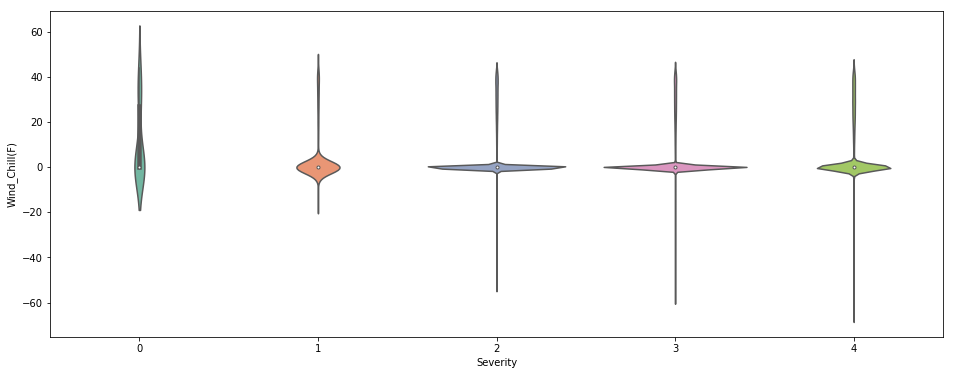

In [40]:
# Severity Impact by Wind_Chill
plt.figure(figsize = (16, 6))
ax = sns.violinplot(y="Wind_Chill(F)", x="Severity", data=acc_df, palette="Set2")

* Severe accidents happen with windchill 0 degree F in peak of winter.

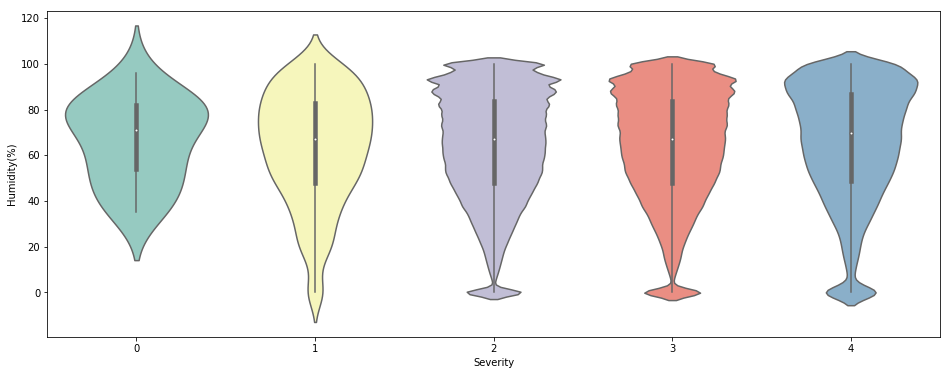

In [41]:
# Severity Impact by Humidity
plt.figure(figsize = (16, 6))
ax = sns.violinplot(y="Humidity(%)", x="Severity", data=acc_df, palette="Set3")

* Severe accidents occur when humidity is around 80% 

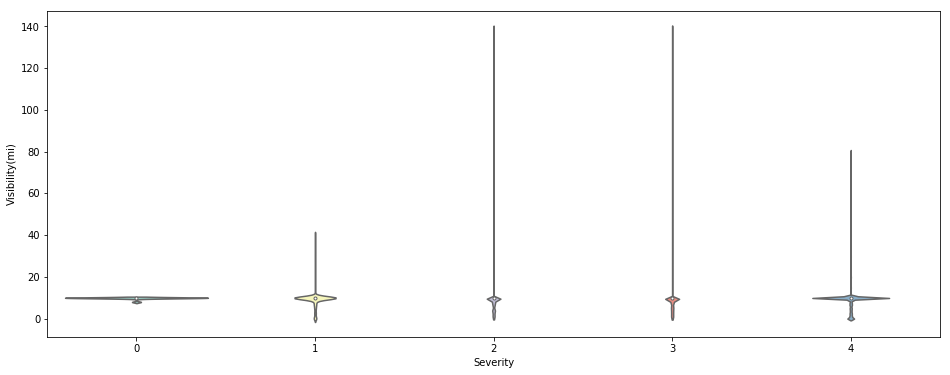

In [42]:
# Severity Impact by Visibility
plt.figure(figsize = (16, 6))
ax = sns.violinplot(y="Visibility(mi)", x="Severity", data=acc_df, palette="Set3")

* Severe accidents occur when visibility is low (0-5 miles)

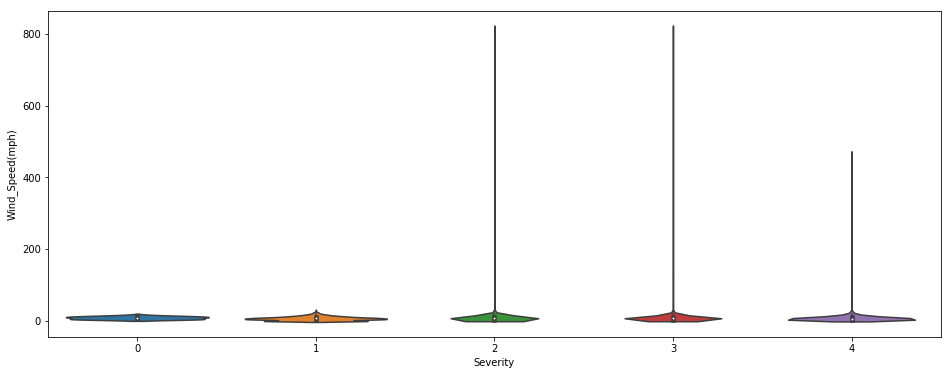

In [43]:
# Severity Impact by Windspeed
plt.figure(figsize = (16, 6))
ax = sns.violinplot(y="Wind_Speed(mph)", x="Severity", data=acc_df)

* We cannot clearly demarkate the impact of windspeed with severity
* Windspeed ranges between 0 to 800. Highest winspeed ever recorded in US in 254 miles/hr (https://www.thoughtco.com/fast-wind-speed-recorded-3444498)

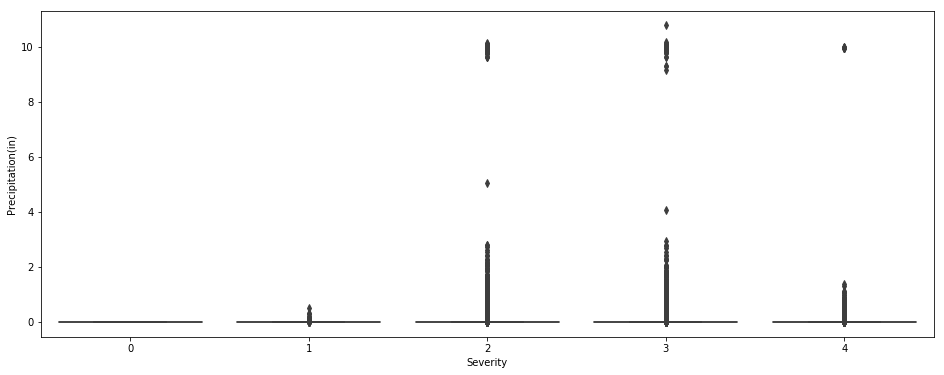

In [44]:
# Severity Impact by Precipitation
plt.figure(figsize = (16, 6))
ax = sns.boxplot(y="Precipitation(in)", x="Severity", data=acc_df)

Can't determine from data if there is a clear co-relation between precipitation and Severity[](http://)

In [45]:
# Co-relation between Precipitation and Sverity
acc_df[['Precipitation(in)', 'Severity']].corr()

,Precipitation(in),Severity
Precipitation(in),1.000000,0.005104
Severity,0.005104,1.000000


In [46]:
# Weather_Condition
acc_df['Weather_Condition'].unique().tolist()

['Light Rain',
 'Overcast',
 'Mostly Cloudy',
 'Rain',
 'Light Snow',
 'Haze',
 'Scattered Clouds',
 'Partly Cloudy',
 'Clear',
 'Snow',
 'Light Freezing Drizzle',
 'Light Drizzle',
 'Fog',
 'Shallow Fog',
 'Heavy Rain',
 'Light Freezing Rain',
 0,
 'Drizzle',
 'Light Rain Showers',
 'Mist',
 'Smoke',
 'Patches of Fog',
 'Light Freezing Fog',
 'Light Haze',
 'Light Thunderstorms and Rain',
 'Thunderstorms and Rain',
 'Volcanic Ash',
 'Blowing Sand',
 'Widespread Dust',
 'Rain Showers',
 'Hail',
 'Heavy Drizzle',
 'Thunderstorm',
 'Heavy Thunderstorms and Rain',
 'Funnel Cloud',
 'Blowing Snow',
 'Light Thunderstorms and Snow',
 'Heavy Snow',
 'Low Drifting Snow',
 'Light Ice Pellets',
 'Ice Pellets',
 'Squalls',
 'Light Fog',
 'Sand',
 'Snow Grains',
 'Snow Showers',
 'Heavy Thunderstorms and Snow',
 'Heavy Ice Pellets',
 'Heavy Freezing Rain',
 'Small Hail',
 'Heavy Rain Showers',
 'Light Snow Showers',
 'Heavy Blowing Snow',
 'Light Hail',
 'Heavy Smoke',
 'Heavy Thunderstorms with S

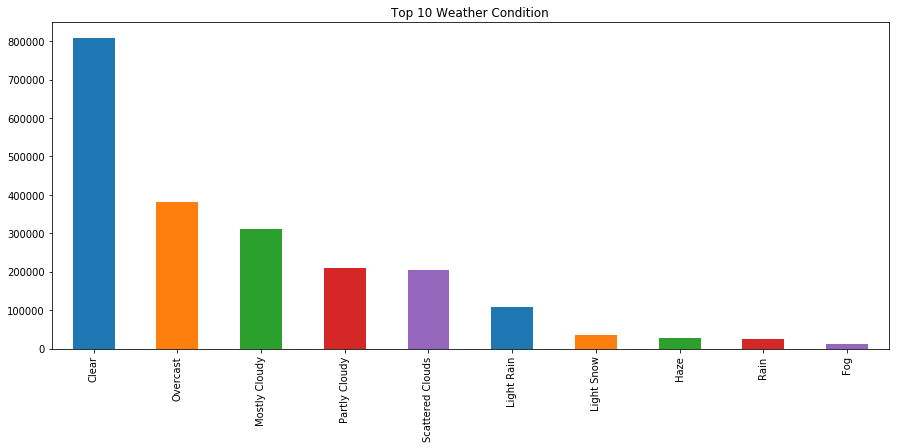

In [47]:
# Top 10 weather condition
plt.figure(figsize = (15, 6))
acc_df[acc_df['Weather_Condition'] != 0]['Weather_Condition'].value_counts().iloc[:10].plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4'], title='Top 10 Weather Condition')

* Most accidents happend in clear conditions.

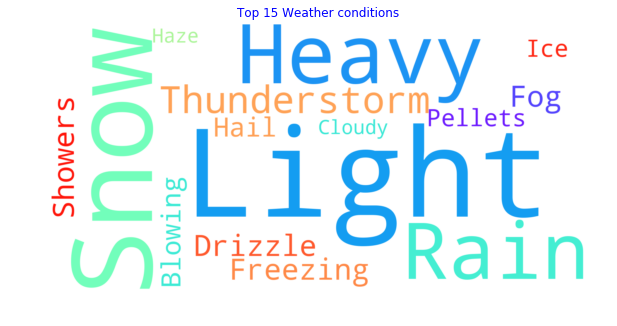

In [48]:
# Weather_Condition Word Cloud
from wordcloud import WordCloud
weather_cond = acc_df["Weather_Condition"].str.split("(").str[0].value_counts().keys()
wc = WordCloud(scale=5,max_words=15,colormap="rainbow",background_color="white").generate(" ".join(weather_cond))
plt.figure(figsize=(10,10))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.title("Top 15 Weather conditions",color='b')
plt.show()

In [49]:
# Start_LatShows latitude in GPS coordinate of the start point.
# Start_LngShows longitude in GPS coordinate of the start point.

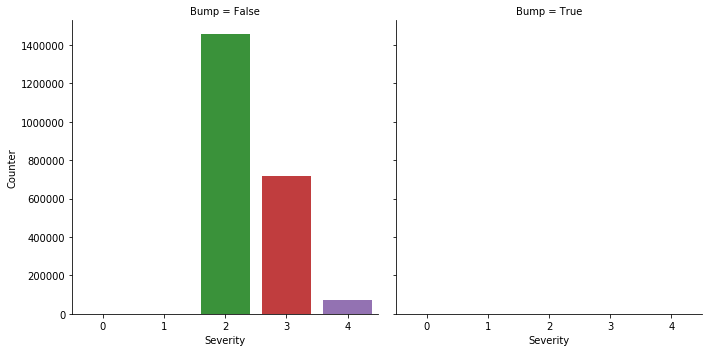

In [50]:
# Severity by Bump
bump_df = acc_df.groupby(['Bump', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Bump", data=bump_df, kind="bar")

* Accidents mostly happend where there were no bumps

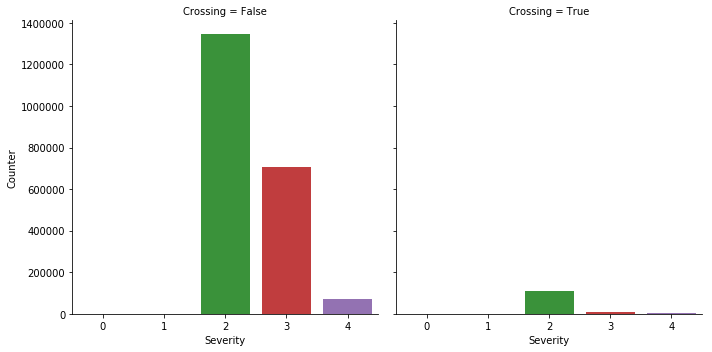

In [51]:
# Severity by Crossing
cross_df = acc_df.groupby(['Crossing', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Crossing", data=cross_df, kind="bar")

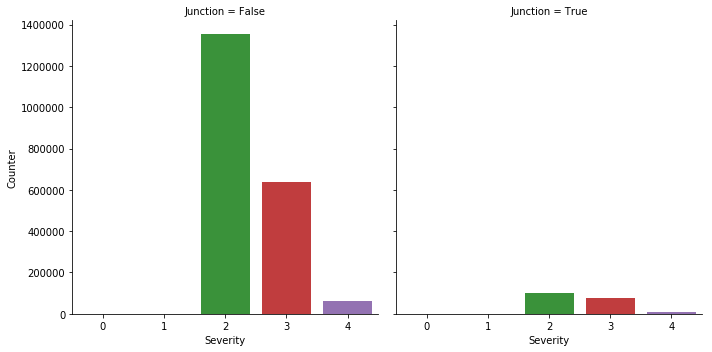

In [52]:
# Severity by Junction 
junc_df = acc_df.groupby(['Junction', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Junction", data=junc_df, kind="bar")

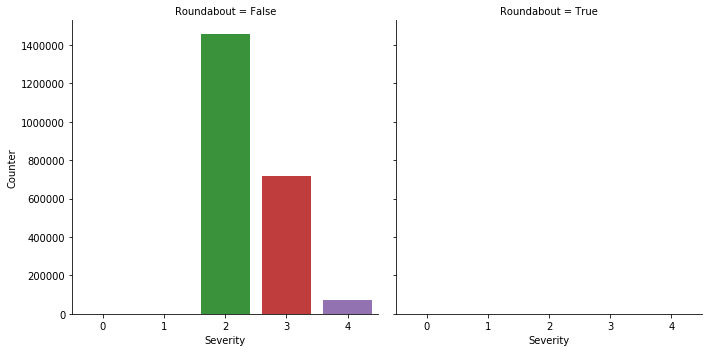

In [53]:
# Severity by Roundabouts 
rndabt_df = acc_df.groupby(['Roundabout', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Roundabout", data=rndabt_df, kind="bar")

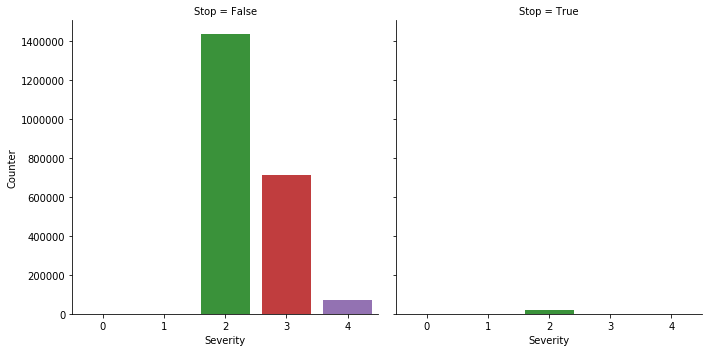

In [54]:
# Severity by Stop Sign 
stop_df = acc_df.groupby(['Stop', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Stop", data=stop_df, kind="bar")

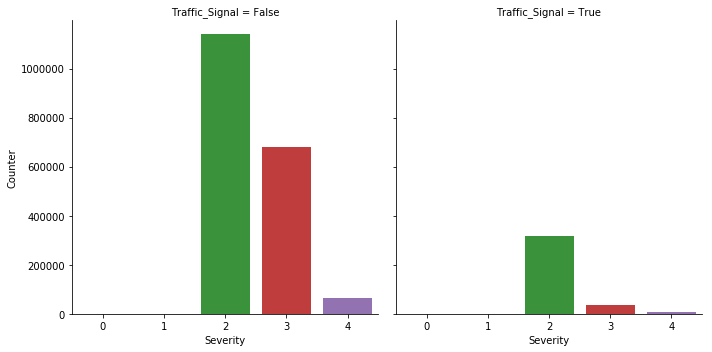

In [55]:
# Severity by Traffic Signal 
stop_df = acc_df.groupby(['Traffic_Signal', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Traffic_Signal", data=stop_df, kind="bar")

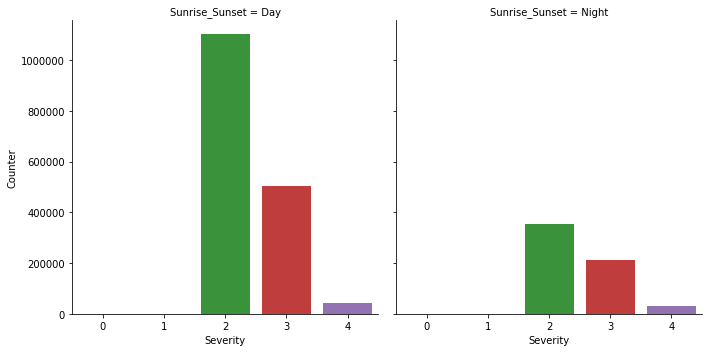

In [56]:
# Severity by Traffic Signal 
ssnt_df = acc_df[acc_df['Sunrise_Sunset'] != 0].groupby(['Sunrise_Sunset', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Sunrise_Sunset", data=ssnt_df, kind="bar")

  Civil_Twilight  Severity  Counter
0            Day         0       14
1            Day         1      654
2            Day         2  1175952
3            Day         3   539770
4            Day         4    45000
5          Night         0        3
6          Night         1      160
7          Night         2   279523
8          Night         3   175802
9          Night         4    26983


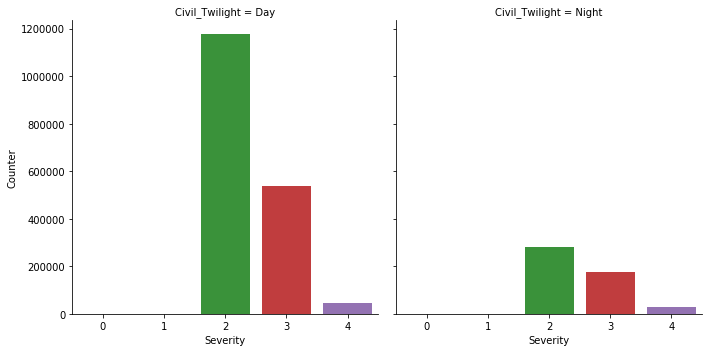

In [57]:
# Severity by Civil Twilight
ssnt_df = acc_df[acc_df['Civil_Twilight'] != 0].groupby(['Civil_Twilight', 'Severity'])['Counter'].sum().reset_index()
print(ssnt_df)
sns.factorplot("Severity", "Counter", col="Civil_Twilight", data=ssnt_df, kind="bar")

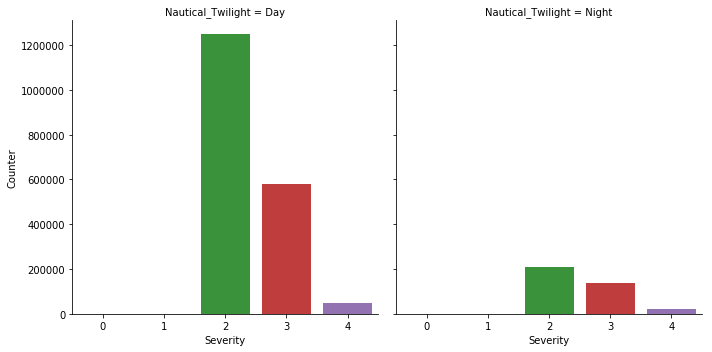

In [58]:
# Severity by Nautical_Twilight
ssnt_df = acc_df[acc_df['Nautical_Twilight'] != 0].groupby(['Nautical_Twilight', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Severity", "Counter", col="Nautical_Twilight", data=ssnt_df, kind="bar")

* Daytime has more severe accidents.


In [59]:
# Let's zoom into start_time column to see what hours are more severe
acc_df_ts = acc_df[['Start_Time', 'Severity', 'Counter']]
acc_df_ts['Time'] = acc_df_ts['Start_Time'].map(lambda x: x.time().strftime('%H:%M'))
acc_df_ts.head()

,Start_Time,Severity,Counter,Time
0,2016-02-08 05:46:00,3,1,05:46
1,2016-02-08 06:07:59,2,1,06:07
2,2016-02-08 06:49:27,2,1,06:49
3,2016-02-08 07:23:34,3,1,07:23
4,2016-02-08 07:39:07,2,1,07:39


In [60]:
# Extracting hrs. from Start_time
acc_df_ts['Hrs'] = acc_df_ts['Start_Time'].map(lambda x: x.time().strftime('%H'))
acc_df_ts.head()

,Start_Time,Severity,Counter,Time,Hrs
0,2016-02-08 05:46:00,3,1,05:46,05
1,2016-02-08 06:07:59,2,1,06:07,06
2,2016-02-08 06:49:27,2,1,06:49,06
3,2016-02-08 07:23:34,3,1,07:23,07
4,2016-02-08 07:39:07,2,1,07:39,07


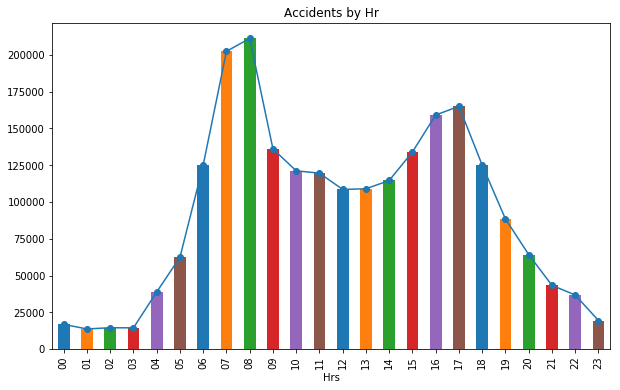

In [61]:
# Plotting hrs against complete accidient list
plt.figure(figsize = (10, 6))
ax = acc_df_ts.groupby(['Hrs'])['Counter'].sum().plot(kind='line', linestyle='-', marker='o', use_index=False)
acc_df_ts.groupby(['Hrs'])['Counter'].sum().plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5'], title='Accidents by Hr', ax = ax)

* Accidents peak between 7am to 9am and between 4 pm to 5pm.

<Figure size 1080x720 with 0 Axes>

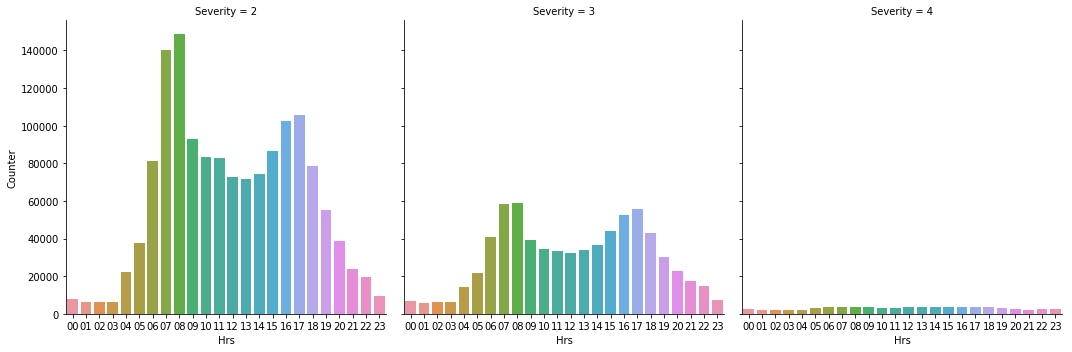

In [62]:
# Severity by Hrs.
plt.figure(figsize = (15, 10))
acc_time_df = acc_df_ts[acc_df_ts['Severity']>1].groupby(['Hrs', 'Severity'])['Counter'].sum().reset_index()
sns.factorplot("Hrs", "Counter", col="Severity", data=acc_time_df, kind="bar")

* Thank You for going thru the Kernel. If you liked it please feel free to upvote.
* If you want to get connected, my linked profile - https://www.linkedin.com/in/jagannath-banerjee/